### Example 2 advanced (OCEL): Loops + Performance (Time)

In [51]:
# 1. Setup and load data:

import os
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [53]:
# 2. Load OCEL & Flatten:

ocel = pm4py.read_ocel("BPIC19.jsonocel")

objects_df = ocel.objects
obj_type_col = ocel.object_type_column
most_common_type = objects_df[obj_type_col].value_counts().index[0]

classic_log = pm4py.ocel_flattening(ocel, most_common_type)

print("Object type:", most_common_type)
print("Cases (classic):", len(classic_log))


Object type: POItem
Cases (classic): 1595923


In [69]:
# 3. Variant analysis
# Rebuild filtered_log from classic_log

variants = pm4py.get_variants(classic_log)
print("Total variants:", len(variants))

sorted_variants = sorted(variants.items(), key=lambda x: x[1], reverse=True)

TOP_K = 10
top_variants = [v[0] for v in sorted_variants[:TOP_K]]

filtered_log = pm4py.filter_variants(classic_log, top_variants)

print("Filtered cases:", len(filtered_log))


Total variants: 26378
Filtered cases: 0


In [71]:
# 4. Loop/Rework analysis

MAX_TRACES = 5000

df = pm4py.convert_to_dataframe(filtered_log)
print("Columns:", df.columns.tolist()[:15])

case_ids = df["case:concept:name"].drop_duplicates().head(MAX_TRACES)
df_small = df[df["case:concept:name"].isin(case_ids)]

repeat_cases = 0
repeat_act_counter = Counter()

for case_id, g in df_small.groupby("case:concept:name"):
    acts = g["concept:name"].tolist()
    cnt = Counter(acts)
    if any(v > 1 for v in cnt.values()):
        repeat_cases += 1
        for a, v in cnt.items():
            if v > 1:
                repeat_act_counter[a] += 1

loop_rate = repeat_cases / MAX_TRACES
print("Loop rate:", loop_rate)
repeat_act_counter.most_common(10)


Columns: ['ocel:eid', 'time:timestamp', 'concept:name', 'ID', 'cCompany', 'cDocType', 'cGR', 'cGRbasedInvVerif', 'cID', 'cItem', 'cItemCat', 'cItemType', 'cPOID', 'cPurDocCat', 'cSpendAreaText']
Loop rate: 0.0


[]

In [73]:
# 5. Performance (Filtered log)

df_filt = pm4py.convert_to_dataframe(filtered_log)
df_filt["time:timestamp"] = pd.to_datetime(df_filt["time:timestamp"], utc=True, errors="coerce")

# keep cases with >=2 events
valid_filt = df_filt.groupby("case:concept:name").filter(lambda x: len(x) >= 2)

tt_filt = (
    valid_filt.groupby("case:concept:name")["time:timestamp"].max()
    - valid_filt.groupby("case:concept:name")["time:timestamp"].min()
)

throughput_days_filt = tt_filt.dt.total_seconds() / (3600 * 24)

print("Filtered cases with >=2 events:", len(throughput_days_filt))
throughput_days_filt.describe()


Filtered cases with >=2 events: 0


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: time:timestamp, dtype: float64

Full cases with >=2 events: 248899


count    248899.000000
mean         72.339432
std         153.457195
min           0.000000
25%          35.396181
50%          64.326389
75%          98.791667
max       25670.589583
Name: time:timestamp, dtype: float64

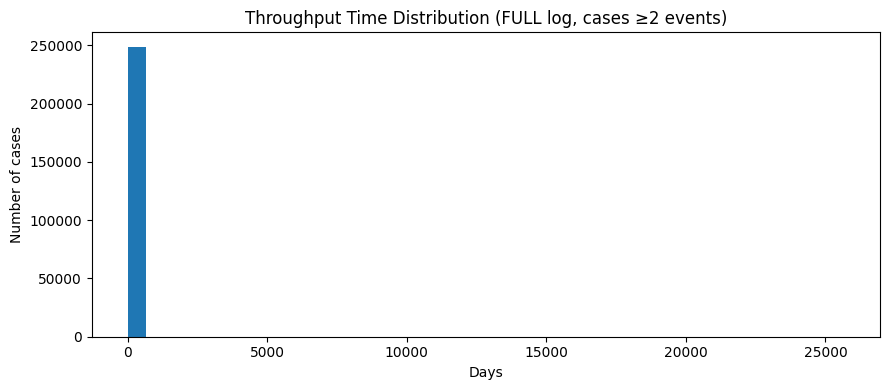

In [75]:
# 6. Throughput Time Analysis for Cases with at Least Two Events

df_full = pm4py.convert_to_dataframe(classic_log)
df_full["time:timestamp"] = pd.to_datetime(df_full["time:timestamp"], utc=True, errors="coerce")

valid_full = df_full.groupby("case:concept:name").filter(lambda x: len(x) >= 2)

tt_full = (
    valid_full.groupby("case:concept:name")["time:timestamp"].max()
    - valid_full.groupby("case:concept:name")["time:timestamp"].min()
)

throughput_days_full = tt_full.dt.total_seconds() / (3600 * 24)

print("Full cases with >=2 events:", len(throughput_days_full))
display(throughput_days_full.describe())

plt.figure(figsize=(9, 4))
plt.hist(throughput_days_full.dropna(), bins=40)
plt.title("Throughput Time Distribution (FULL log, cases ≥2 events)")
plt.xlabel("Days")
plt.ylabel("Number of cases")
plt.tight_layout()
plt.show()


In [76]:
# 7. KPI Summary table (full log)

summary_full = pd.DataFrame({
    "Metric": ["Cases (>=2 events)", "Mean (days)", "Median (days)", "P95 (days)", "Min (days)", "Max (days)"],
    "Value": [
        len(throughput_days_full),
        throughput_days_full.mean(),
        throughput_days_full.median(),
        throughput_days_full.quantile(0.95),
        throughput_days_full.min(),
        throughput_days_full.max()
    ]
})

summary_full


,Metric,Value
0,Cases (>=2 events),248899.000000
1,Mean (days),72.339432
2,Median (days),64.326389
3,P95 (days),142.987500
4,Min (days),0.000000
5,Max (days),25670.589583


filtered_log is empty or not found. Rebuilding from classic_log...
Total variants: 26378
Rebuilt filtered_log cases: 0
Events in filtered log: 0
Cases in filtered log: 0
Cases with >=2 events: 0
Cases used for discovery: 0
Events used for discovery: 0


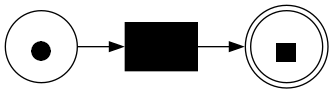

In [81]:
# 8. Process discovery (Filtered log → Petri net)
import pm4py
import pandas as pd

# --------------------------------------------------
# STEP 1: Make sure filtered_log EXISTS and NOT EMPTY
# --------------------------------------------------

if "filtered_log" not in globals() or len(filtered_log) == 0:
    print("filtered_log is empty or not found. Rebuilding from classic_log...")

    variants = pm4py.get_variants(classic_log)
    print("Total variants:", len(variants))

    sorted_variants = sorted(
        variants.items(),
        key=lambda x: x[1],
        reverse=True
    )

    TOP_K = 10   # you can try 20 or 50 later
    top_variants = [v[0] for v in sorted_variants[:TOP_K]]

    filtered_log = pm4py.filter_variants(classic_log, top_variants)
    print("Rebuilt filtered_log cases:", len(filtered_log))
else:
    print("filtered_log exists. Cases:", len(filtered_log))


# --------------------------------------------------
# STEP 2: Convert filtered_log to DataFrame
# --------------------------------------------------

df_filt = pm4py.convert_to_dataframe(filtered_log)
df_filt["time:timestamp"] = pd.to_datetime(
    df_filt["time:timestamp"], utc=True, errors="coerce"
)

print("Events in filtered log:", len(df_filt))
print("Cases in filtered log:", df_filt["case:concept:name"].nunique())


# --------------------------------------------------
# STEP 3: Keep only cases with >= 2 events (IMPORTANT)
# --------------------------------------------------

df_filt_ge2 = df_filt.groupby("case:concept:name").filter(lambda x: len(x) >= 2)

print("Cases with >=2 events:", df_filt_ge2["case:concept:name"].nunique())


# --------------------------------------------------
# STEP 4: Sample cases for discovery (performance reason)
# --------------------------------------------------

SAMPLE_FOR_MODEL = 3000
sample_case_ids = (
    df_filt_ge2["case:concept:name"]
    .drop_duplicates()
    .head(SAMPLE_FOR_MODEL)
)

df_model = df_filt_ge2[df_filt_ge2["case:concept:name"].isin(sample_case_ids)]

print("Cases used for discovery:", df_model["case:concept:name"].nunique())
print("Events used for discovery:", len(df_model))


# --------------------------------------------------
# STEP 5: Discover Petri net (Inductive Miner)
# --------------------------------------------------

net_f, im_f, fm_f = pm4py.discover_petri_net_inductive(
    df_model,
    activity_key="concept:name",
    case_id_key="case:concept:name",
    timestamp_key="time:timestamp"
)

pm4py.view_petri_net(net_f, im_f, fm_f)


In [83]:
# 9. FULL vs FILTERED (TABLE)

comparison = pd.DataFrame({
    "log": ["FULL (>=2 events)", "FILTERED Top variants (>=2 events)"],
    "cases_used": [len(throughput_days_full), len(throughput_days_filt)],
    "mean_days": [throughput_days_full.mean(), throughput_days_filt.mean()],
    "median_days": [throughput_days_full.median(), throughput_days_filt.median()],
    "p95_days": [throughput_days_full.quantile(0.95), throughput_days_filt.quantile(0.95)]
})

comparison


,log,cases_used,mean_days,median_days,p95_days
0,FULL (>=2 events),248899,72.339432,64.326389,142.9875
1,FILTERED Top variants (>=2 events),0,NaN,NaN,NaN
